In [1]:
import sys, os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import shapely
import rioxarray as rxr

sys.path.append(os.path.join(os.getcwd(), '..', '..'))
from gnt.data.common.geobox.geobox import get_or_create_geobox
from odc.geo import CRS
from odc.geo.xr import ODCExtensionDa, assign_crs, xr_reproject

In [2]:
modis = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/glass/LST/MODIS/Daily/1KM/processed/stage_2/modis_timeseries_reprojected.zarr")
modis = modis.rio.write_crs(4326)
#modis_bangladesh = modis.rio.clip_box(*(88.0844222351, 20.670883287, 92.6727209818, 26.4465255803)).compute()

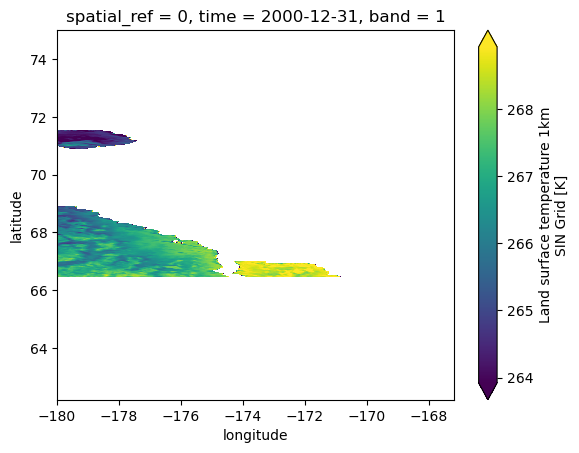

In [3]:
modis.isel(time=0, longitude=slice(1024*3), latitude=slice(1024*3))["mean"].compute().squeeze().plot.imshow(robust=True)

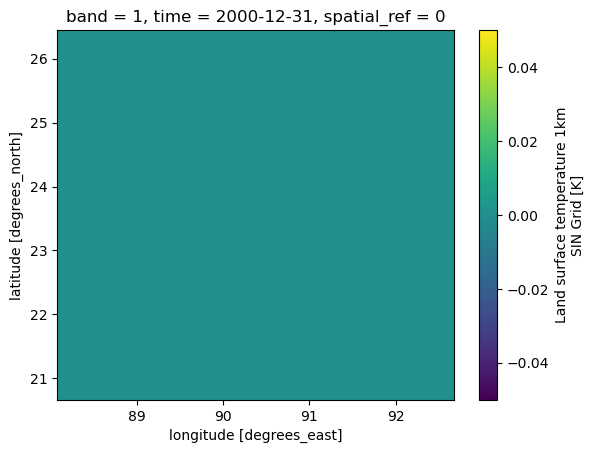

In [3]:
modis_bangladesh["max"].isel(time = 0).squeeze().plot.imshow()

In [2]:
import pickle
from odc.geo.xr import ODCExtensionDa, assign_crs, xr_reproject
from odc.geo.geom import Geometry, box
from odc.geo.geobox import GeoboxTiles
geobox = pickle.load(open("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_0/misc/viirs_geobox.pkl", "rb"))
tiles = GeoboxTiles(geobox, (2048, 2048))
tile_list = [(x, y, tiles[x, y]) for x in range(tiles.shape[0]) for y in range(tiles.shape[1])]

In [3]:
crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

In [4]:
def better_crop(x, geometry):
    bbox = geometry.boundingbox
    return x.sel(x = slice(bbox[0], bbox[2]), y = slice(bbox[1], bbox[3]))

In [9]:
combined_ds = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/glass/LST/MODIS/Daily/1KM/processed/stage_1/2000/temp_combined.tzarr").rio.write_crs(crs)
combined_ds_bangladesh = better_crop(combined_ds, Geometry(gpd.GeoSeries([shapely.box(88.0844222351, 20.670883287, 92.6727209818, 26.4465255803)], crs = 4326).to_crs(crs).iloc[0], crs = crs)).compute()

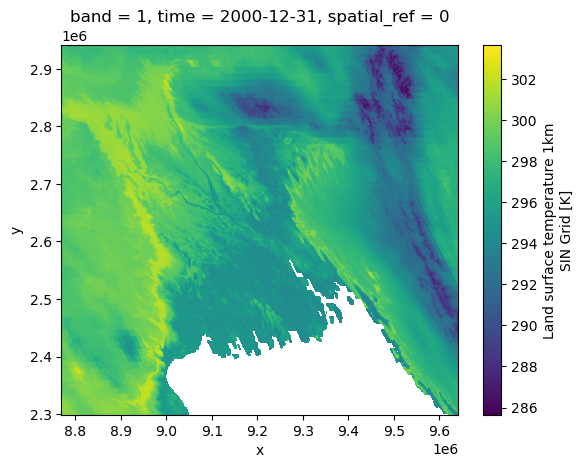

In [12]:
combined_ds_bangladesh["mean"].squeeze().plot.imshow()

In [10]:
test = xr_reproject(combined_ds_bangladesh, 4326)

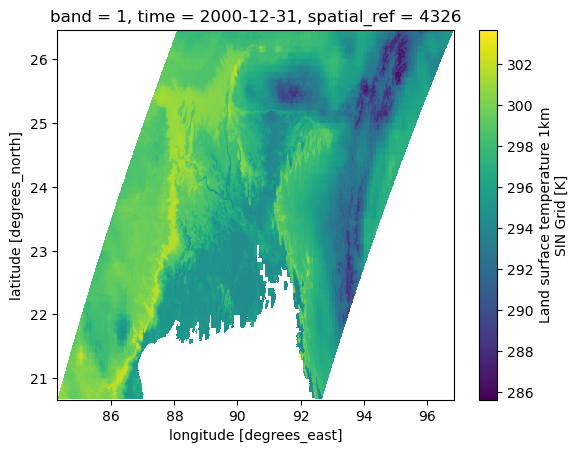

In [13]:
test["mean"].where(test["mean"] > 0).squeeze().plot.imshow()

In [33]:
combined_ds_subset = better_crop(combined_ds, test_geobox.footprint(crs).envelope).compute()

<Axes: title={'center': 'band = 1, spatial_ref = 0, time = 2000-12-31'}, xlabel='x', ylabel='y'>

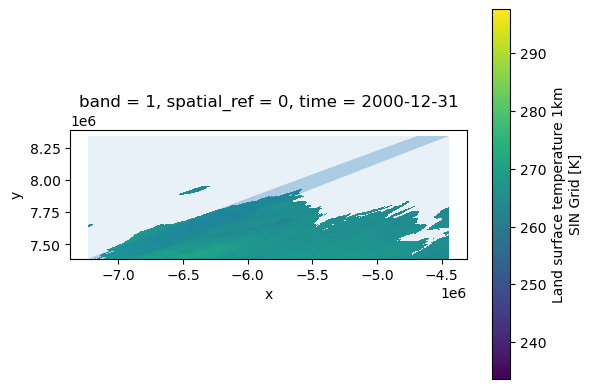

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#test_subset["mean"].squeeze().plot.imshow(ax = ax)
combined_ds_subset["mean"].squeeze().plot.imshow(ax = ax)
import geopandas as gpd
gpd.GeoSeries([test_geobox.footprint(crs).envelope], crs = crs).plot(ax = ax, alpha = .1)
gpd.GeoSeries([test_geobox.footprint(crs)], crs = crs).plot(ax = ax, alpha = .3)

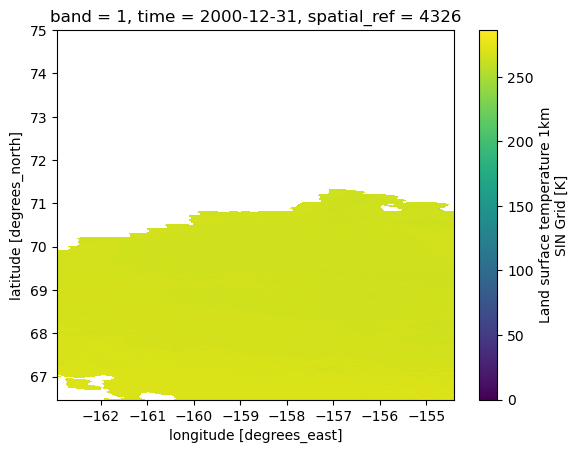

In [36]:
combined_ds_subset.odc.reproject(test_geobox).compute()["mean"].squeeze().plot.imshow()

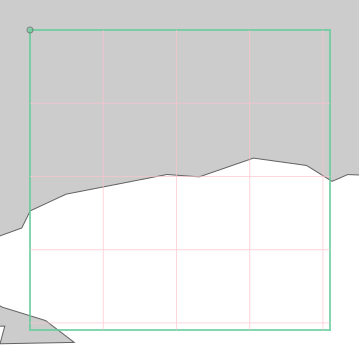

In [47]:
test_geobox

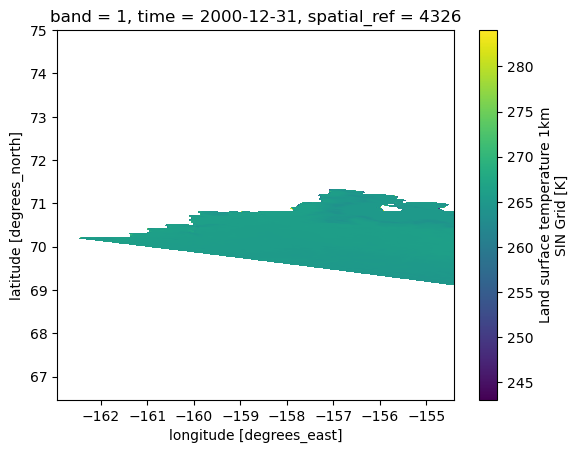

In [46]:
combined_ds_subset.odc.reproject(test_geobox)["mean"].squeeze().plot.imshow()

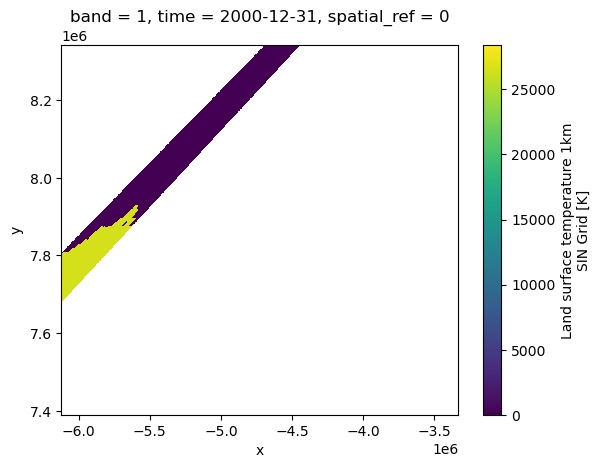

In [26]:
test_subset["mean"].squeeze().plot.imshow()

In [ ]:
test_subset["mean"].odc.assign_crs(crs).odc.reproject(4326)#.squeeze().plot.imshow()

<xarray.DataArray (time: 1, band: 1, latitude: 511, longitude: 21398)> Size: 44MB
array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]]],
      shape=(1, 1, 511, 21398), dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * time         (time) datetime64[ns] 8B 2000-12-31
  * latitude     (latitude) float64 4kB 75.02 75.01 74.99 ... 66.49 66.47 66.46
  * longitude    (longitude) float64 171kB -179.9 -179.9 -179.9 ... 179.4 179.5
    spatial_ref  int32 4B 4326
Attributes: (12/47)
    ASSOCIATEDINSTRUMENTSHORTNAME.1:  MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:    Terra
    ASSOCIATEDSENSORSHORTNAME.1:      MODIS
    BANDDEFINITION:                   END_OBJECT
    CHARACTERISTICBINSIZE:            926.6
    DATACOLUMNS:                      1200
    ...                               ...
    add_offset:                       0.0
    long_name:                        Land surface temperature 1km SIN Grid
    scale_factor:                     0.01
    units:                            K
    nodata:                           0
    _FillValue:                       0

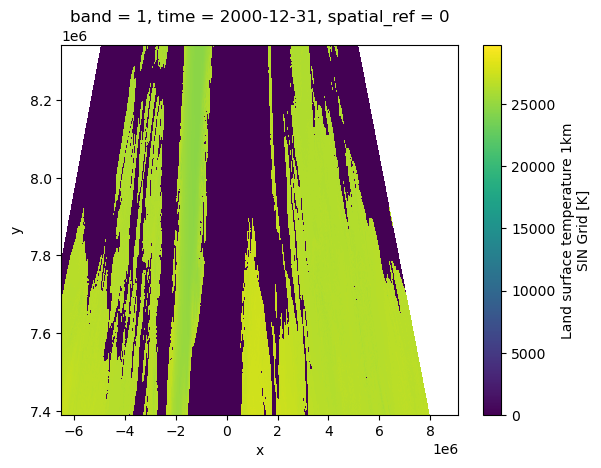

In [11]:
test_subset["mean"].squeeze().plot.imshow()

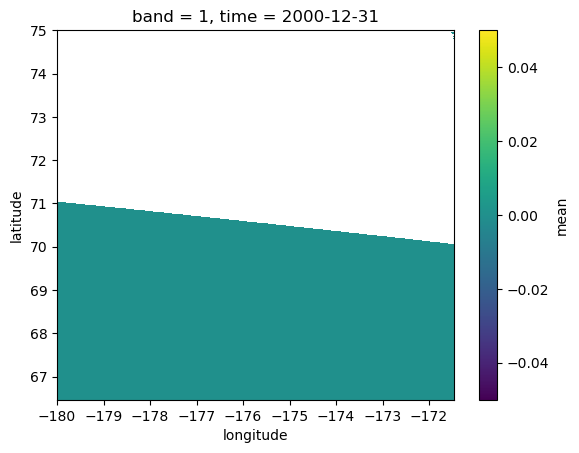

In [7]:
test_reprojected["mean"].squeeze().plot.imshow()

In [39]:
import pickle
from odc.geo.xr import ODCExtensionDa, assign_crs, xr_reproject
from odc.geo.geom import Geometry, box
geobox = pickle.load(open("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_0/misc/viirs_geobox.pkl", "rb"))
from odc.geo.geobox import GeoboxTiles
tiles = GeoboxTiles(geobox, (2048, 2048))
tile = tiles[10,16]

In [40]:
coords = {
    'band': [1],
    'time': [1],
    'latitude': tile.coordinates["latitude"].values,
    'longitude': tile.coordinates["longitude"].values
}

In [78]:
import dask.array as da
import numcodecs

empty_data = {}

# Create empty array with proper fill value
empty_array = xr.DataArray(
    da.full(
        (1, 1, len(coords['latitude']), len(coords['longitude'])),
        1,
        dtype='uint16',
        chunks=(1, 1, 256, 256)
    ),
    dims=['band', 'time', 'latitude', 'longitude'],
    coords=coords
)
empty_data["test_1"] = empty_array
empty_data["test_2"] = empty_array
            
# Create dataset
empty_ds = xr.Dataset(empty_data)

# Set CRS information
empty_ds = empty_ds.rio.write_crs(tile.crs)


# Set up compression for Zarr output
compressor = numcodecs.Blosc(cname="zstd", clevel=3, shuffle=2)
encoding = {
    var: {
        'chunks': (1, 1, 256, 256),
        'compressor': compressor,
        'dtype': str(empty_ds[var].dtype)
    } for var in ["test_1", "test_2"]
}

# Write empty zarr store
empty_ds.to_zarr(
    "/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/glass/LST/MODIS/Daily/1KM/tmp/test.zarr",
    mode="w",
    encoding=encoding,
    consolidated=False,
    compute=False
)

Delayed('_finalize_store-bb353139-23be-49ed-a52d-3f87388f8657')

In [62]:
empty_ds

<xarray.Dataset> Size: 17MB
Dimensions:      (band: 1, time: 1, latitude: 2048, longitude: 2048)
Coordinates:
  * band         (band) int64 8B 1
  * time         (time) int64 8B 1
  * latitude     (latitude) float64 16kB -10.33 -10.34 -10.34 ... -18.86 -18.86
  * longitude    (longitude) float64 16kB -43.47 -43.46 -43.46 ... -34.94 -34.94
    spatial_ref  int64 8B 0
Data variables:
    test_1       (band, time, latitude, longitude) uint16 8MB dask.array<chunksize=(1, 1, 256, 256), meta=np.ndarray>
    test_2       (band, time, latitude, longitude) uint16 8MB dask.array<chunksize=(1, 1, 256, 256), meta=np.ndarray>

In [81]:
test = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/glass/LST/MODIS/Daily/1KM/tmp/test.zarr", consolidated = False, chunks = None, mask_and_scale = False)
test.test_1.values

array([[[[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]]],
      shape=(1, 1, 2048, 2048), dtype=uint16)

In [80]:
insert_dataset = dict()
insert_dataset["test_1"] = empty_array.isel(latitude = slice(0, 1024), longitude = slice(0, 1024))
insert_dataset["test_2"] = empty_array.isel(latitude = slice(0, 1024), longitude = slice(0, 1024))

insert_dataset = xr.Dataset(insert_dataset)

insert_dataset.to_zarr(
    "/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/glass/LST/MODIS/Daily/1KM/tmp/test.zarr",
    region = {
        "time": "auto", "band": "auto",
        "latitude": slice(0, 1024), "longitude": slice(0, 1024)
        },
    consolidated = False
)

In [9]:
modis_bangladesh["mean"].isnull().mean()

<xarray.DataArray 'mean' ()> Size: 8B
array(1.)
Coordinates:
    spatial_ref  int64 8B 0

Tiles: 17x43|2048x2048px => 33_601x86_401px

In [18]:
5*17-97

-12

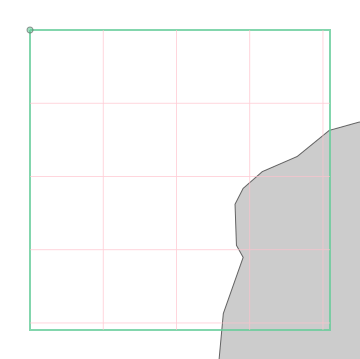

: 

In [ ]:
GeoboxTiles(geobox, (8192/4, 8192/4))[5,9]

In [21]:
modis_cell = modis.rio.clip_box(*GeoboxTiles(geobox, (8192/4, 8192/4))[5,9].boundingbox)["mean"].compute()

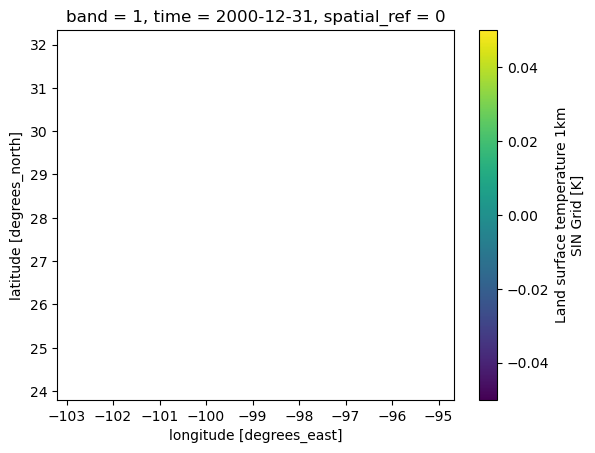

In [22]:
modis_cell.isel(time = 0).squeeze().plot.imshow()

In [9]:
modis_bangladesh["mean"]#.squeeze().isnull().mean(axis = 1).mean(axis=1)#.isel(time=3)#.isel(time=3).plot.imshow()

<xarray.DataArray 'mean' (band: 1, time: 21, latitude: 1387, longitude: 1102)> Size: 257MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], shape=(1, 21, 1387, 1102))
Coordinates:
  * band         (band) int64 8B 1
  * latitude     (latitude) float64 11kB 26.45 26.44 26.44 ... 20.68 20.67 20.67
  * longitude    (longitude) float64 9kB 88.08 88.09 88.09 ... 92.66 92.67 92.67
  * time         (time) datetime64[ns] 168B 2000-12-31 2001-12-31 ... 2020-12-31
    spatial_ref  int64 8B 0
Attributes: (12/43)
    ASSOCIATEDINSTRUMENTSHORTNAME.1:  MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:    Terra
    ASSOCIATEDSENSORSHORTNAME.1:      MODIS
    BANDDEFINITION:                   END_OBJECT
    CHARACTERISTICBINSIZE:            926.6
    DATACOLUMNS:                      1200
    ...                               ...
    VERSIONID:                        1
    VERTICALTILENUMBER:               4
    WEBSITE:                          http://glass-product.bnu.edu.cn
    WESTHBOUNDINGCOORDINATE:          -13.025755
    long_name:                        Land surface temperature 1km SIN Grid
    units:                            K

In [10]:
viirs = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/eog/viirs/processed/stage_2/viirs_annual_timeseries_reprojected.zarr", decode_coords="all")
viirs = viirs.rio.write_crs(4326)
viirs_bangladesh = viirs.rio.clip_box(*(88.0844222351, 20.670883287, 92.6727209818, 26.4465255803)).compute()

In [11]:
land_mask = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_2/osm/land_mask.zarr")
land_mask = land_mask.rio.write_crs(4326)
land_mask_bangladesh = land_mask.rio.clip_box(*(88.0844222351, 20.670883287, 92.6727209818, 26.4465255803)).land_mask.compute()

In [27]:
modis_bangladesh = modis_bangladesh.where(land_mask_bangladesh)
viirs_bangladesh = viirs_bangladesh.where(land_mask_bangladesh)

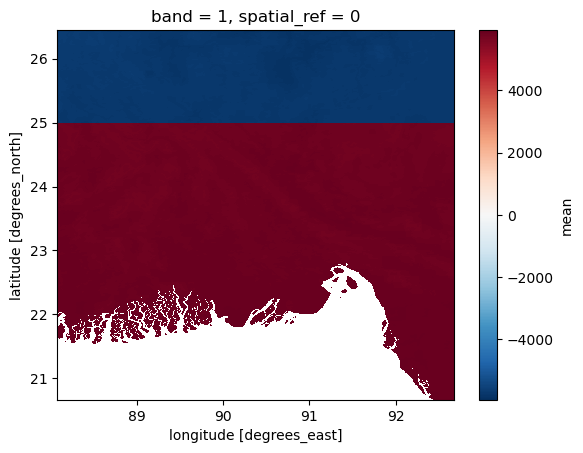

In [13]:
(modis_bangladesh["mean"].sel(time = slice("2010-12-31", "2019-12-31")).mean(dim = "time") - 
 modis_bangladesh["mean"].sel(time = slice("2000-12-31", "2009-12-31")).mean(dim = "time")).squeeze().plot.imshow()

/scicore/home/meiera/schulz0022/miniforge-pypy3/envs/gnt/lib/python3.11/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


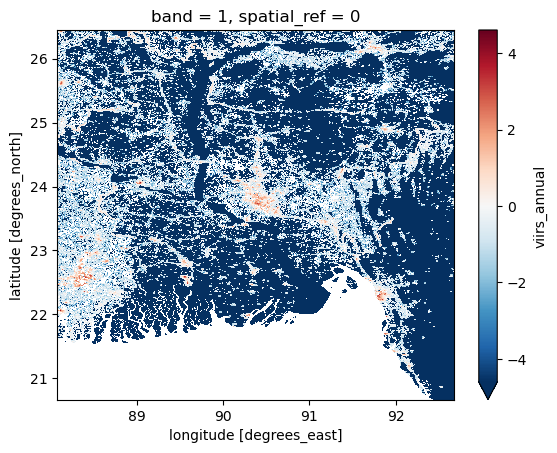

In [7]:
np.log(viirs_bangladesh["viirs_annual"].sel(time = "2020-12-31", band = 1) - viirs_bangladesh["viirs_annual"].sel(time = "2013-12-31", band = 1) + 0.01).plot.imshow(robust = True)

In [8]:
viirs_bangladesh

<xarray.Dataset> Size: 61MB
Dimensions:       (time: 10, band: 1, latitude: 1387, longitude: 1102)
Coordinates:
  * band          (band) int64 8B 1
  * latitude      (latitude) float64 11kB 26.45 26.44 26.44 ... 20.67 20.67
  * longitude     (longitude) float64 9kB 88.08 88.09 88.09 ... 92.67 92.67
  * time          (time) datetime64[ns] 80B 2012-12-31 2013-12-31 ... 2021-12-31
    spatial_ref   int64 8B 0
Data variables:
    viirs_annual  (time, band, latitude, longitude) float32 61MB 0.2089 ... 0.0

In [9]:
merged = xr.combine_by_coords(
    [
        modis_bangladesh["mean"].squeeze(),
        viirs_bangladesh["viirs_annual"].squeeze()
    ],
    combine_attrs="override"
)

In [10]:
merged_df = merged.to_dataframe().dropna()

In [14]:
merged_df

band  spatial_ref   mean  viirs_annual
latitude  longitude time                                              
26.445833 88.083335 2012-12-31     1            0  282.0      0.208900
                    2013-12-31     1            0  282.0      0.000000
                    2014-12-31     1            0  282.0      0.000000
                    2015-12-31     1            0  282.0      0.408697
                    2016-12-31     1            0  282.0      0.000000
...                              ...          ...    ...           ...
20.670833 92.670836 2016-12-31     1            0  293.0      0.000000
                    2017-12-31     1            0  293.0      0.000000
                    2018-12-31     1            0  293.0      0.000000
                    2019-12-31     1            0  294.0      0.000000
                    2020-12-31     1            0  293.0      0.000000

[11019564 rows x 4 columns]

<Axes: xlabel='mean', ylabel='viirs_annual'>

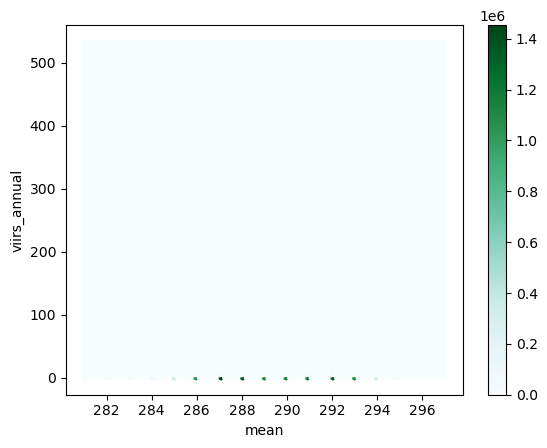

In [13]:
merged_df[["mean", "viirs_annual"]].plot(x = "mean", y = "viirs_annual", kind = "hexbin")